<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Learning
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Introduction to Machine Learning
<br>
</font>
<font size=5>
Instructor: Dr. M. Bejani
<br>
</font>
<font size=4>
Spring 2025
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: TBD
</font>
<hr>
<font color='red'  size=4>
Note: It is highly recommended to run your notebook on Google Colab or Kaggle
<br>
</font>
<font face="Times New Roman" size=4 align=center>

</font>
<br>
<hr>
</div></font>

In this part we are going to use Restricterd Boltzman Machine(RBM) in practice, So we first impliment the class of RBM and then load the MNIST datset witch is very famous dataset and mainly used for education purposes and then train the RBM model on it

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
Name = "MohammadParsa Dini"
StudentId = "400101204"

In [ ]:
# Here we need to import the libraries that we are going to use
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import os
from google.colab import drive

if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'

print(torch.device)

cuda


# define RBM class
here base on what you had learned in the class, impliment the RBM class, then we are going to instanciate this class for the training.


In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows:

$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$


In [ ]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=5):
        super(RBM, self).__init__()
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.1)
        self.k = k

    def visible_to_hidden(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W.t(), self.h_bias))
        return p_h

    def hidden_to_visible(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W, self.v_bias))
        return p_v

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v_bias)
        h_term = torch.sum(F.softplus(F.linear(v, self.W.t(), self.h_bias)), dim=1)
        return -v_term - h_term

    def forward(self, v):
        v_gibb = v
        for _ in range(self.k):
            h_prob = self.visible_to_hidden(v_gibb)
            h_sample = torch.bernoulli(h_prob)
            v_prob = self.hidden_to_visible(h_sample)
            v_gibb = torch.bernoulli(v_prob)
        return v, v_gibb

    def sample(self, num_samples, steps=1000, device='cpu'):
        v = torch.rand(num_samples, self.v_bias.size(0)).to(device)
        for _ in range(steps):
            h_prob = self.visible_to_hidden(v)
            h_sample = torch.bernoulli(h_prob)
            v_prob = self.hidden_to_visible(h_sample)
            v = torch.bernoulli(v_prob)
        return v

In [ ]:
torch.manual_seed(42)

# Define output directory in Google Drive
output_dir = '/content/drive/MyDrive/rbm_output'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

def train(model, train_loader, n_epochs=20, lr=0.001, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(n_epochs):
        loss_list = []
        recon_error_list = []
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)
            v = (data > 0.5).float()
            v, v_gibbs = model(v)
            loss = torch.mean(model.free_energy(v) - model.free_energy(v_gibbs))
            recon_error = torch.mean((v - v_gibbs) ** 2)
            loss_list.append(loss.item())
            recon_error_list.append(recon_error.item())

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Visualize first batch of each epoch
            if batch_idx == 0:
                show_and_save(make_grid(v.view(-1, 1, 28, 28).cpu()), f'real_epoch_{epoch}')
                show_and_save(make_grid(v_gibbs.view(-1, 1, 28, 28).cpu()), f'fake_epoch_{epoch}')

        print(f'Epoch {epoch}\t Loss={np.mean(loss_list):.4f}\t Recon Error={np.mean(recon_error_list):.4f}')
    return model

def show_and_save(img, file_name):
    np_img = np.transpose(img.numpy(), (1, 2, 0))
    f = os.path.join(output_dir, f'{file_name}.png')  # Save to Google Drive
    plt.imshow(np_img, cmap='gray')
    plt.axis('off')
    plt.imsave(f, np_img)
    plt.close()

# Hyperparameters
batch_size = 64
n_epochs = 20
lr = 0.001
n_hid = 128
n_vis = 784
k = 5

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize and train model
model = RBM(n_vis, n_hid, k=k).to(device)
model = train(model, train_loader, n_epochs=n_epochs, lr=lr, device=device)

# Generate and visualize samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=batch_size, steps=1000, device=device)
    show_and_save(make_grid(samples.view(-1, 1, 28, 28).cpu()), 'generated_samples')

# Optional: Display the final generated samples in Colab
from IPython.display import Image, display
display(Image(filename=os.path.join(output_dir, 'generated_samples.png')))

Using device: cuda
Epoch 0	 Loss=-35.7413	 Recon Error=0.1663
Epoch 1	 Loss=-17.3515	 Recon Error=0.1077
Epoch 2	 Loss=-14.5214	 Recon Error=0.0987
Epoch 3	 Loss=-13.0827	 Recon Error=0.0934
Epoch 4	 Loss=-11.9557	 Recon Error=0.0898
Epoch 5	 Loss=-11.0639	 Recon Error=0.0870
Epoch 6	 Loss=-10.5160	 Recon Error=0.0847
Epoch 7	 Loss=-10.1553	 Recon Error=0.0830
Epoch 8	 Loss=-9.7479	 Recon Error=0.0812
Epoch 9	 Loss=-9.6084	 Recon Error=0.0799
Epoch 10	 Loss=-9.3535	 Recon Error=0.0785
Epoch 11	 Loss=-9.0408	 Recon Error=0.0772
Epoch 12	 Loss=-8.9020	 Recon Error=0.0762
Epoch 13	 Loss=-8.7119	 Recon Error=0.0752
Epoch 14	 Loss=-8.5550	 Recon Error=0.0743
Epoch 15	 Loss=-8.3663	 Recon Error=0.0734
Epoch 16	 Loss=-8.1938	 Recon Error=0.0726
Epoch 17	 Loss=-8.0190	 Recon Error=0.0718
Epoch 18	 Loss=-7.7253	 Recon Error=0.0710
Epoch 19	 Loss=-7.4907	 Recon Error=0.0703


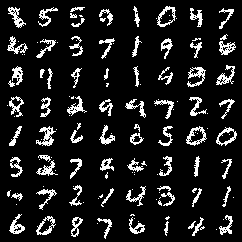

In [ ]:
# Optional: Display the final generated samples in Colab
from IPython.display import Image, display

# plt.figure(figsize=(15,15))
# for i in range(5):
#   for j in range(4):

display(Image(filename=os.path.join(output_dir, 'fake_epoch_19.png')))

here for showing how the model works, load images from "train_loader" and then feed it to the model, show real images and generated images

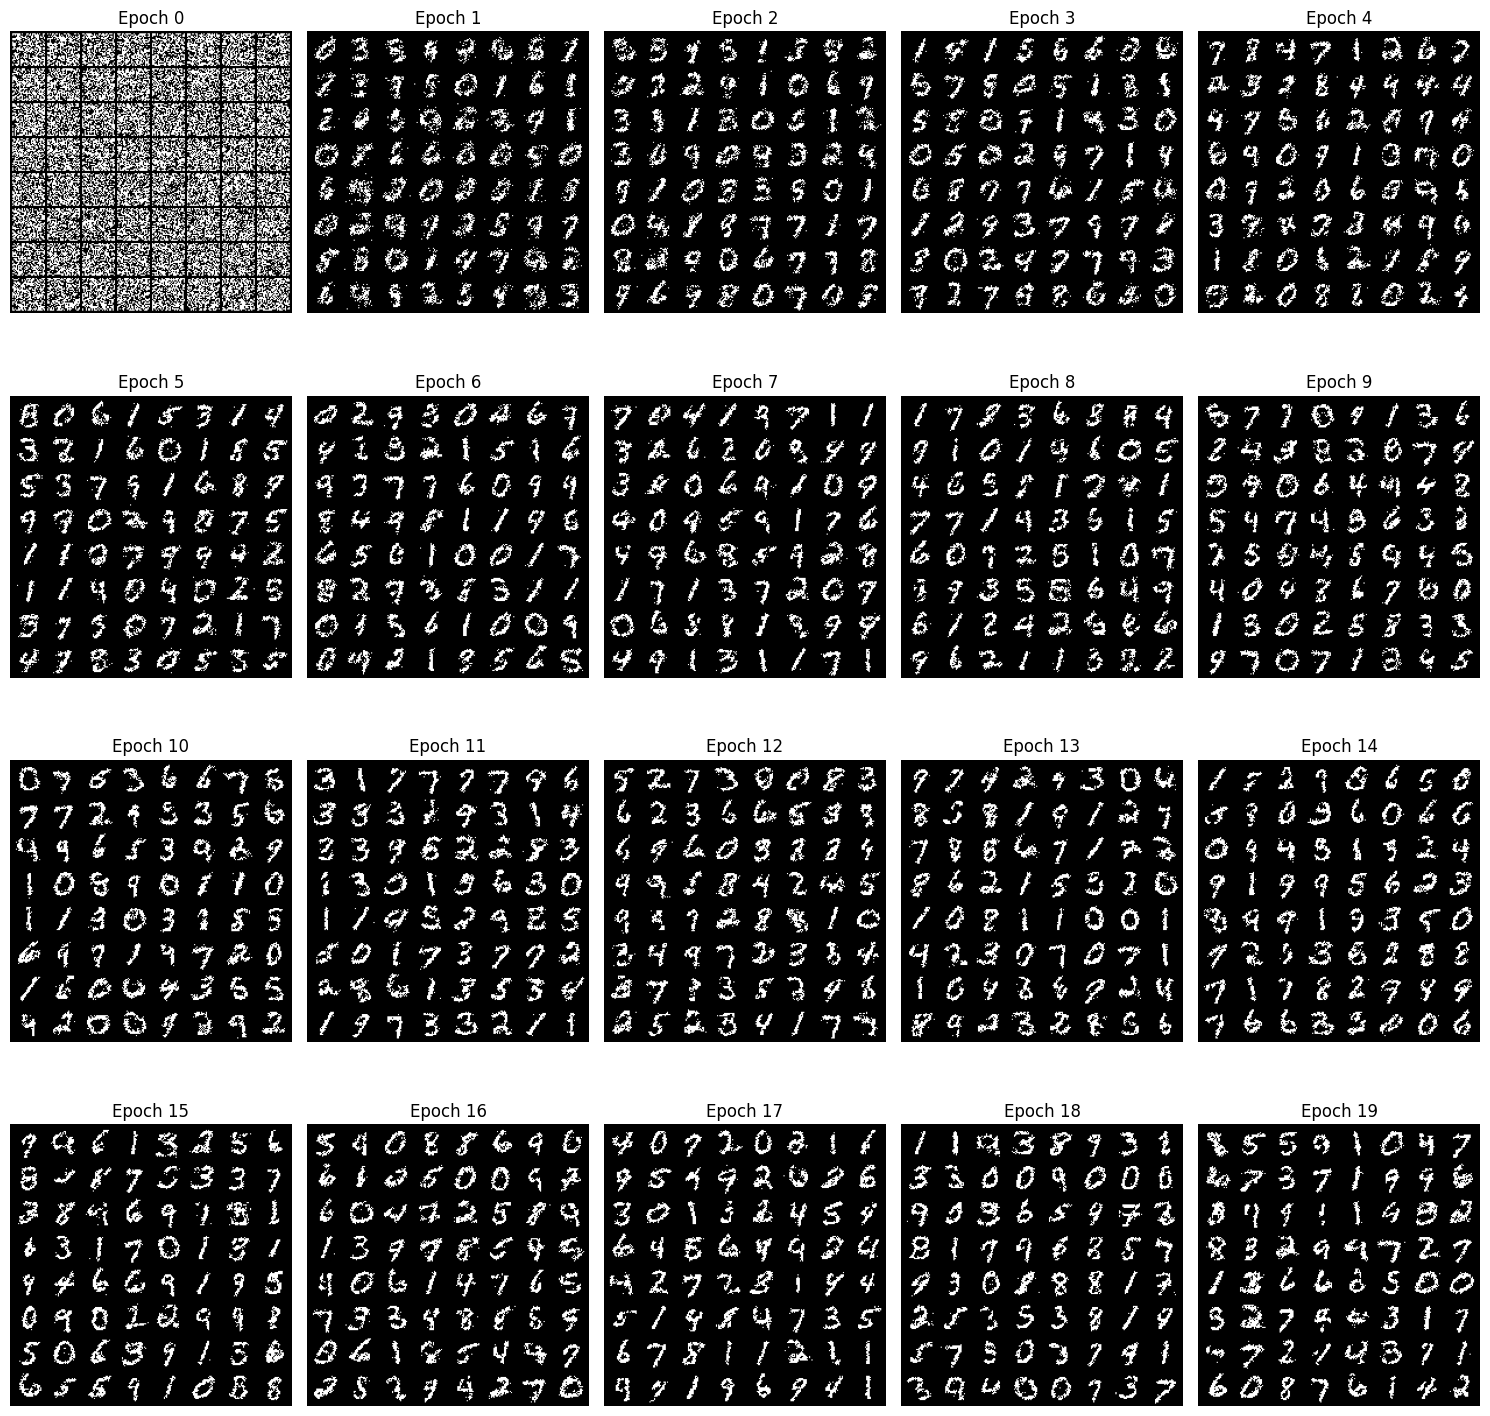

In [ ]:
plt.figure(figsize=(15, 15))
fake_dir = output_dir
for i in range(4):  # 4 rows
    for j in range(5):  # 5 columns
        epoch = i * 5 + j  # Now epoch goes from 0 to 19
        ax = plt.subplot(4, 5, epoch + 1)  # 1-based indexing for subplot
        img_path = os.path.join(fake_dir, f'fake_epoch_{epoch}.png')
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Epoch {epoch}')
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, f'No image\nEpoch {epoch}', ha='center', va='center')
            ax.axis('off')
plt.tight_layout()
plt.show()


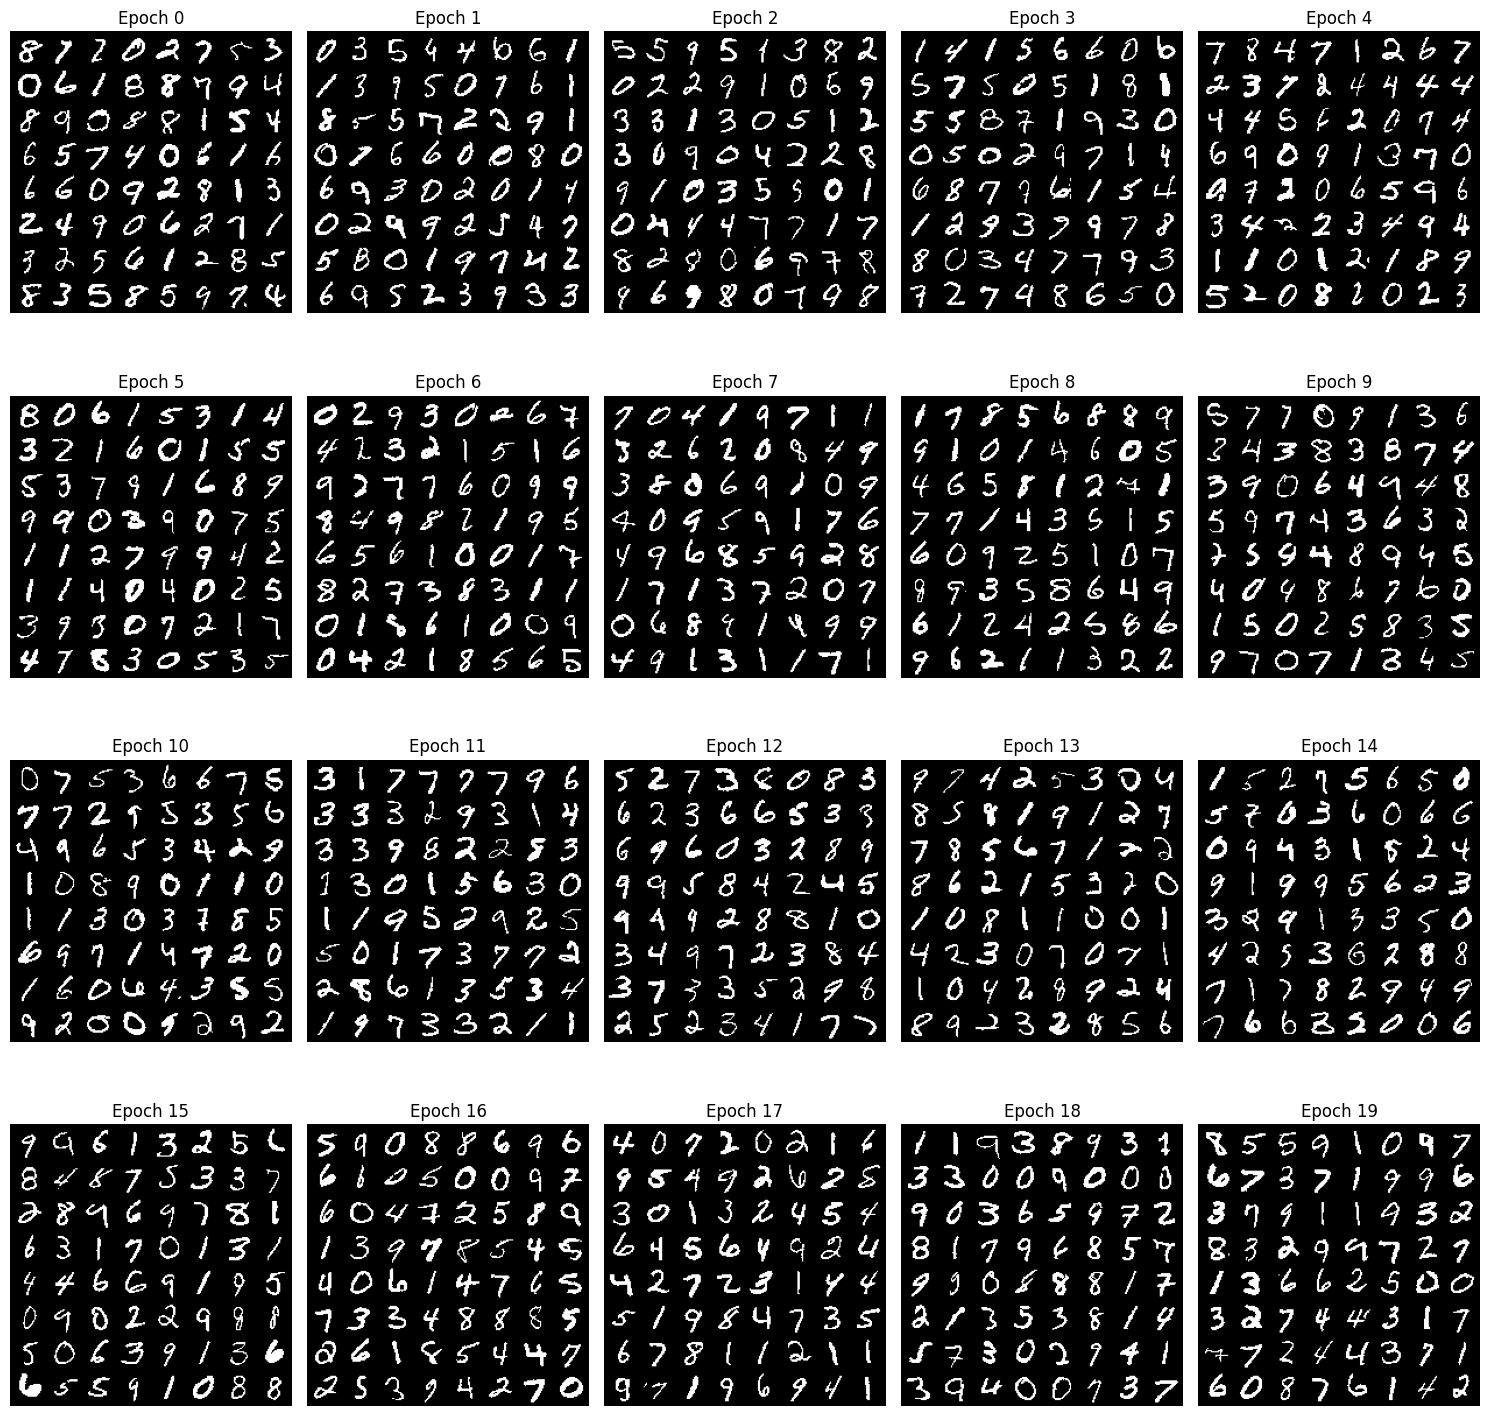

In [ ]:
plt.figure(figsize=(15, 15))
fake_dir = output_dir
for i in range(4):  # 4 rows
    for j in range(5):  # 5 columns
        epoch = i * 5 + j  # Now epoch goes from 0 to 19
        ax = plt.subplot(4, 5, epoch + 1)  # 1-based indexing for subplot
        img_path = os.path.join(fake_dir, f'real_epoch_{epoch}.png')
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Epoch {epoch}')
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, f'No image\nEpoch {epoch}', ha='center', va='center')
            ax.axis('off')
plt.tight_layout()
plt.show()